In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import glob
import json
import numpy as np
import pandas as pd
import sqlite3 as sql
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from grid_search_graph import generate_plot

sns.set()

In [2]:
base_dir = "/tmp/grid_search"

results = glob.glob(os.path.join(base_dir, "*", "results.json"))
histories = glob.glob(os.path.join(base_dir, "*", "history.npz"))

data = []
for i, (r, h) in enumerate(zip(sorted(results), sorted(histories))):
    his = np.load(h, allow_pickle=True)
    his = his['arr_0'].tolist()
    
    with open(r, 'r') as f:
        j = json.load(f)
    j["nn_fps"] = int(np.mean(j["nn_fps"]))
    for k, v in j["config"].items():
        j[k] = v
    del j["config"]
    
    if "expansions" in j:
        del j["expansions"]
        
    for l, s in enumerate(j["layers_filters"]):
        j["layer{}_filter".format(l)] = s
    j["layers_filters"] = ",".join([str(s) for s in j["layers_filters"]])

    del j["last_mAP"]
    
    j["input_height"] = j["size_value"][0]
    j["input_width"] = j["size_value"][1]
    del j["size_value"]
    
    per_epoch_values = {int(e): (ap, stat[1]) for (e, ap), stat in zip(j['mAPs'], j["stats"])}
    ths = sorted(j['mAPs'][0][1].keys())
    
    del j['stats']
    del j['mAPs']
    
    for epoch, (loss, val_loss) in enumerate(zip(his['loss'], his['val_loss'])):
        epoch = int(epoch)
        if epoch in per_epoch_values:
            for th in ths:
                j_copy = {k: v for k, v in j.items()}
                j_copy["epoch"] = epoch
                j_copy["loss"] = loss
                j_copy["val_loss"] = val_loss
                j_copy["mAP"] = per_epoch_values[epoch][0][th]
                j_copy["TP"] = per_epoch_values[epoch][1][0][th]
                j_copy["FP"] = per_epoch_values[epoch][1][1][th]
                j_copy["FN"] = per_epoch_values[epoch][1][2][th]
                j_copy["iou_threshold"] = th
                data.append(j_copy.values())
        else:
            j_copy = {k: v for k, v in j.items()}
            j_copy["epoch"] = epoch
            j_copy["loss"] = loss
            j_copy["val_loss"] = val_loss
            j_copy["mAP"] = None
            j_copy["TP"] = None
            j_copy["FP"] = None
            j_copy["FN"] = None
            j_copy["iou_threshold"] = None
            data.append(j_copy.values())
            
df = pd.DataFrame(data, columns=j_copy.keys())

con = sql.Connection(":memory:")

con.enable_load_extension(True)
con.load_extension("./extension-functions")

df.to_sql("glob_stats", con)

print(len(df))
print(j.keys())

1886
dict_keys(['nn_fps', 'prediction_count', 'flops', 'dropout_rate', 'dropout_strategy', 'layers_filters', 'layer0_filter', 'layer1_filter', 'layer2_filter', 'layer3_filter', 'input_height', 'input_width'])


Selecting data for dropout_strategy = all
Selecting data for dropout_strategy = last


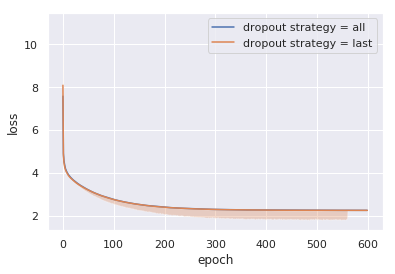

In [38]:
generate_plot(con, "epoch", "loss", "dropout_strategy", {})

Selecting data for dropout_strategy = all
Selecting data for dropout_strategy = last


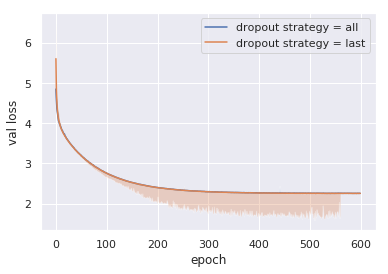

In [39]:
generate_plot(con, "epoch", "val_loss", "dropout_strategy", {})

Selecting data for dropout_rate = 0.1
Selecting data for dropout_rate = 0.2
Selecting data for dropout_rate = 0.3
Selecting data for dropout_rate = 0.4
Selecting data for dropout_rate = 0.5
Selecting data for dropout_rate = 0.6
Selecting data for dropout_rate = 0.7
Selecting data for dropout_rate = 0.8


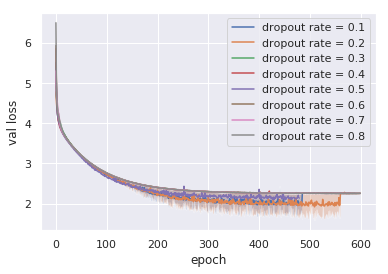

In [40]:
generate_plot(con, "epoch", "val_loss", "dropout_rate", {})

Selecting data for dropout_rate = 0.1
Selecting data for dropout_rate = 0.2
Selecting data for dropout_rate = 0.3
Selecting data for dropout_rate = 0.4
Selecting data for dropout_rate = 0.5
Selecting data for dropout_rate = 0.6
Selecting data for dropout_rate = 0.7
Selecting data for dropout_rate = 0.8


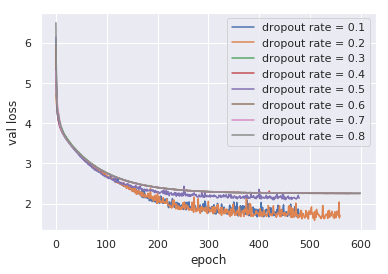

In [41]:
generate_plot(con, "epoch", "val_loss", "dropout_rate", {"dropout_strategy": ["last"]})

Selecting data for dropout_rate = 0.1
Selecting data for dropout_rate = 0.2
Selecting data for dropout_rate = 0.3
{0.1:      epoch       min       max    median      mean
0        0  4.884632  4.884632  4.884632  4.884632
1        1  4.491318  4.491318  4.491318  4.491318
2        2  4.305195  4.305195  4.305195  4.305195
3        3  4.185204  4.185204  4.185204  4.185204
4        4  4.100371  4.100371  4.100371  4.100371
5        5  4.040866  4.040866  4.040866  4.040866
6        6  4.002536  4.002536  4.002536  4.002536
7        7  3.973606  3.973606  3.973606  3.973606
8        8  3.935643  3.935643  3.935643  3.935643
9        9  3.910209  3.910209  3.910209  3.910209
10      10  3.874410  3.874410  3.874410  3.874410
11      11  3.848239  3.848239  3.848239  3.848239
12      12  3.826422  3.826422  3.826422  3.826422
13      13  3.814943  3.814943  3.814943  3.814943
14      14  3.774405  3.774405  3.774405  3.774405
15      15  3.756455  3.756455  3.756455  3.756455
16      16  3

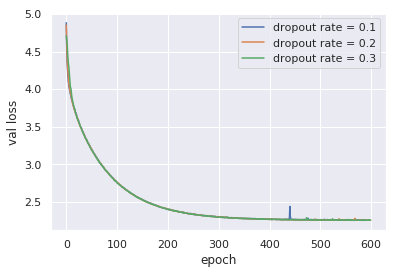

In [49]:
generate_plot(con, "epoch", "val_loss", "dropout_rate", {"dropout_strategy": ["all"]})

Selecting data for dropout_rate = 0.1
Selecting data for dropout_rate = 0.2
Selecting data for dropout_rate = 0.3
Selecting data for dropout_rate = 0.4
Selecting data for dropout_rate = 0.5
Selecting data for dropout_rate = 0.6
Selecting data for dropout_rate = 0.7
Selecting data for dropout_rate = 0.8


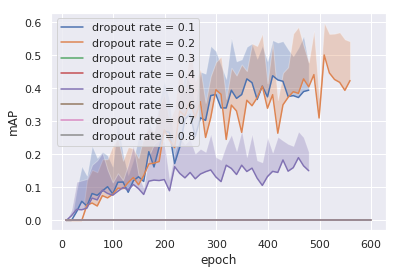

In [53]:
generate_plot(con, "epoch", "mAP", "dropout_rate", {"dropout_strategy": ["last"]})

Selecting data for dropout_strategy = all
Selecting data for dropout_strategy = last


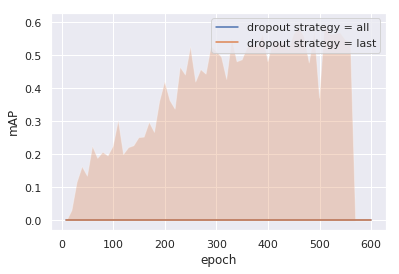

In [54]:
generate_plot(con, "epoch", "mAP", "dropout_strategy", {})